In [15]:
import sys
import os

sys.path.append('..')

import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from mrmr import mrmr_classif

from src.machinelearning import (
    ANNClassifier,
    cross_val_sklearn,
    evaluate_ann,
    evaluate_sklearn,
    get_predictions,
    train_ann,
    train_decisiontree,
    train_skoperules,
    train_xgboost,
)
from src.ml2rules import TreeRuler, ml2tree, sample_from_df
from src.mlexplain import *
from src.utils import get_cc_mat, get_dataset, non_stratify_split, stratify_split

In [4]:
def get_value_counts(df: pd.DataFrame) -> None:
    display(
        pd.DataFrame(
        data=[df['label'].value_counts(normalize=True).round(4), df['label'].value_counts()],
        index=["percentage", "absolute"]    
    ).T
    )

# Data preprocessing

(492, 1314)
(492, 1243)


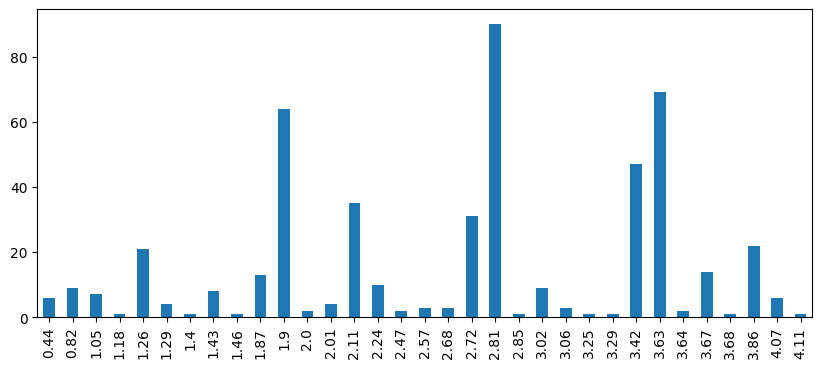

In [5]:
filename = '../data/dataset_experimental_KPI.xlsx'
df = pd.read_excel(filename, sheet_name='Sheet1', index_col=0)
df.reset_index(drop=True, inplace=True)
df = df.drop(df.index[-2:])
# get all non-numeric columns
non_numeric_columns = df.select_dtypes(exclude=['number']).columns
df.drop(non_numeric_columns, axis=1, inplace=True)
# Print 10 last cols
cols_to_drop = df.iloc[:, -11:-1].columns.values
df.drop(cols_to_drop, axis=1, inplace=True) 
print(df.shape)

# Drop columns that contain any value greater than 1; Exclude "KPI" column
kpi_col = df['KPI']
df = df.loc[:, (df <= 1).all()]
df = df.loc[:, (df >= 0).all()]
df['KPI'] = kpi_col
del kpi_col
print(df.shape)

plt.figure(figsize=(10, 4))
df['KPI'].value_counts().sort_index().plot(kind='bar')
plt.show()

# Create a new column 'label' with values 1 if KPI >= 3, 0 otherwise
df['label'] = df['KPI'].apply(lambda x: 1 if x >= 3 else 0)
df['label'].value_counts(normalize=True)
df.drop('KPI', axis=1, inplace=True)

# Save the cleaned dataset
df.to_csv('../data/dataset_experimental_KPI_cleaned.csv', index=False)

In [6]:
get_value_counts(df)

,percentage,absolute
0,0.6423,316.0
1,0.3577,176.0


# Machine Learning - Rule extraction pipeline

In [7]:
df = pd.read_csv('../data/dataset_experimental_KPI_cleaned.csv')
df.shape

(492, 1243)

In [9]:
# Train-test split
train_test_split = False
if train_test_split:
    X_train, X_test, y_train, y_test = stratify_split(data=df, train_size=392, target="label")
else:
    # Use all data
    X_train = df.drop('label', axis=1)
    y_train = df['label']

    X_test = X_train.copy()
    y_test = y_train.copy()

    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)
    
print(f'Training set shape: {X_train.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (492, 1242)
Test set shape: (492, 1242)


In [28]:
if os.path.exists('../models/yeast_exp/xgboost_model_full.pkl'):
    with open('../models/yeast_exp/xgboost_model_full.pkl', 'rb') as f:
        xgb_model = pickle.load(f)
else:
    xgb_model = train_xgboost(X_train, y_train, scoring='matthews_corrcoef', n_trials=100)
    with open('../models/yeast_exp/xgboost_model_full.pkl', 'wb') as f:
        pickle.dump(xgb_model, f)

In [17]:
print('Cross validation:')
cross_val_sklearn(xgb_model, X_train, y_train)

Cross validation:
Accuracy: 0.8557
Precision: 1.0
Recall: 0.5957
F1: 0.7394
ROC AUC: 0.9333
MCC: 0.6962


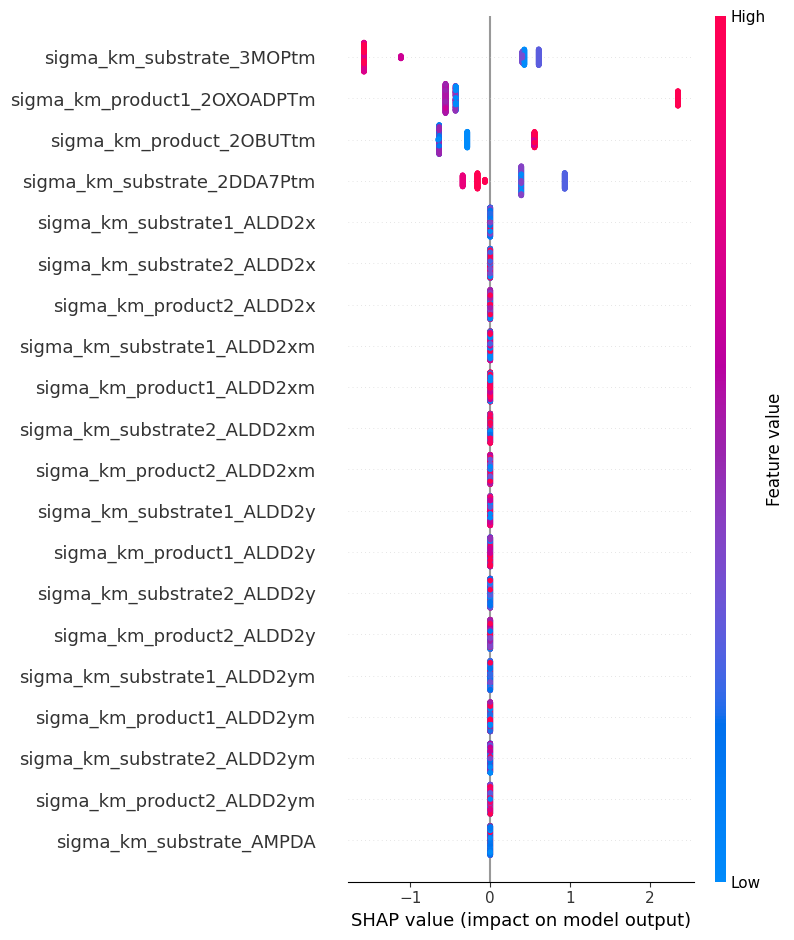

In [46]:
# Get shap values
shap_values_df = get_shap_values(xgb_model, X_train)

# Plot shap values
plt.figure(figsize=(10, 4))
shap.summary_plot(shap_values_df.values, X_train, plot_type='dot', max_display=10)
plt.show()

### Decision Tree - iSHRUNCK

In [ ]:
cart_model = train_decisiontree(X_train, y_train, scoring='matthews_corrcoef', n_trials=200)

In [48]:
# Cross-validated performance
cross_val_sklearn(cart_model, X_train, y_train)

Accuracy: 0.8171
Precision: 0.8792


Recall: 0.6522
F1: 0.7107
ROC AUC: 0.9345
MCC: 0.6278


(492, 1242)

In [181]:
ruler = TreeRuler(df=train_df, tree_clf=cart_model, target="label")
ruler.get_rules()
print(f'Number of rules: {len(ruler.rules)}')
ruler.rules

Number of rules: 4


['if (sigma_km_substrate1_D_LACt2m > 0.354) and (sigma_km_substrate23_LMPD_s_0450_c_1_256 <= 0.94) then class: 1 (proba: 100.0%) | based on 209 samples',
 'if (sigma_km_substrate1_D_LACt2m <= 0.354) then class: 0 (proba: 100.0%) | based on 105 samples',
 'if (sigma_km_substrate1_D_LACt2m > 0.354) and (sigma_km_substrate23_LMPD_s_0450_c_1_256 > 0.94) and (sigma_km_product1_ICDHyr <= 0.61) then class: 1 (proba: 58.25%) | based on 103 samples',
 'if (sigma_km_substrate1_D_LACt2m > 0.354) and (sigma_km_substrate23_LMPD_s_0450_c_1_256 > 0.94) and (sigma_km_product1_ICDHyr > 0.61) then class: 1 (proba: 62.67%) | based on 75 samples']

In [187]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(train_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['sigma_km_substrate1_D_LACt2m<=0.354']
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0


### Skope - Rules

In [ ]:
skope_rules_clf = train_skoperules(X_train, y_train, scoring='f1')

In [191]:
# Print skope-rules rules
print(f'*** Number of rules {len(skope_rules_clf.rules_)}')

# Get rules
for i in skope_rules_clf.rules_[:10]:
    print(i)

*** Number of rules 5
('sigma_km_substrate1_ACS > 0.7776683568954468', (1.0, 0.6056338028169014, 2))
('sigma_km_product2_ACACT1r > 0.03748328285291791 and sigma_km_product2_CBPS > 0.6794790625572205 and sigma_km_product2_IMPD > 0.5016605630517006', (0.41379310344827586, 0.26865671641791045, 2))
('sigma_km_product2_CITtbm <= 0.5084617137908936 and sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_substrate17_LMPD_s_0450_c_1_256 > 0.3877897784113884', (0.42045454545454547, 0.2569444444444444, 2))
('sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_product_Kt2r <= 0.45622797682881355 and sigma_km_substrate2_ME2m > 0.01983820367604494', (0.4024390243902439, 0.2357142857142857, 2))
('sigma_km_product2_CITtbm > 0.5084617137908936 and sigma_km_substrate_E4Ptm <= 0.6500734984874725 and sigma_km_substrate17_LMPD_s_0450_c_1_256 > 0.3877897784113884', (0.38596491228070173, 0.1527777777777778, 2))


In [199]:
rule = skope_rules_clf.rules_[0][0]
print(rule)
sampled_df = sample_from_df(test_df, rule, skope_rules=True)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

sigma_km_substrate1_ACS > 0.7776683568954468
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0


### XGBoost

In [ ]:
xgb_preds = xgb_model.predict(X_train)
xgb2tree = ml2tree(X_train, xgb_preds, cv=10, scoring='f1', n_trials=100)

In [203]:
cross_val_sklearn(xgb2tree, X_train, y_train)

Accuracy: 0.8171
Precision: 0.8792
Recall: 0.6522
F1: 0.7107
ROC AUC: 0.9333
MCC: 0.6278


In [206]:
ruler = TreeRuler(df=train_df, tree_clf=xgb2tree, target="label")
ruler.get_rules()
ruler.rules

['if (sigma_km_substrate_MALt > 0.195) then class: 1 (proba: 100.0%) | based on 387 samples',
 'if (sigma_km_substrate_MALt <= 0.195) then class: 0 (proba: 100.0%) | based on 105 samples']

In [213]:
rule = ruler.get_rule_constraints(1)
print(rule)
sampled_df = sample_from_df(test_df, rule)
print(f'Number of parameter sets following the rule: {sampled_df.shape[0]}')
get_value_counts(sampled_df)

['sigma_km_substrate_MALt<=0.195']
Number of parameter sets following the rule: 105


,percentage,absolute
1,1.0,105.0


In [218]:
df[df['sigma_km_substrate_MALt'] <= 0.195].index.values

array([  0,   1,   2,   5,   8,  11,  14,  17,  20,  23,  26,  29,  32,
        35,  38,  41,  44,  48,  53,  58,  62,  66,  71,  76,  80,  85,
        90,  94,  98, 103, 108, 113, 118, 123, 129, 134, 139, 144, 149,
       154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 203, 208, 213,
       218, 223, 228, 233, 238, 243, 248, 253, 258, 264, 270, 276, 281,
       286, 292, 298, 303, 309, 315, 320, 325, 330, 335, 340, 345, 350,
       356, 362, 368, 374, 380, 386, 392, 398, 404, 409, 414, 419, 424,
       429, 434, 439, 444, 449, 454, 459, 464, 468, 472, 476, 480, 484,
       488])

In [219]:
df[df['sigma_km_substrate1_ACS'] > 0.7777].index.values

array([  0,   1,   2,   5,   8,  11,  14,  17,  20,  23,  26,  29,  32,
        35,  38,  41,  44,  48,  53,  58,  62,  66,  71,  76,  80,  85,
        90,  94,  98, 103, 108, 113, 118, 123, 129, 134, 139, 144, 149,
       154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 203, 208, 213,
       218, 223, 228, 233, 238, 243, 248, 253, 258, 264, 270, 276, 281,
       286, 292, 298, 303, 309, 315, 320, 325, 330, 335, 340, 345, 350,
       356, 362, 368, 374, 380, 386, 392, 398, 404, 409, 414, 419, 424,
       429, 434, 439, 444, 449, 454, 459, 464, 468, 472, 476, 480, 484,
       488])

In [224]:
df[df['sigma_km_substrate1_D_LACt2m'] <= 0.354].index.values

array([  0,   1,   2,   5,   8,  11,  14,  17,  20,  23,  26,  29,  32,
        35,  38,  41,  44,  48,  53,  58,  62,  66,  71,  76,  80,  85,
        90,  94,  98, 103, 108, 113, 118, 123, 129, 134, 139, 144, 149,
       154, 159, 164, 169, 174, 179, 184, 189, 194, 199, 203, 208, 213,
       218, 223, 228, 233, 238, 243, 248, 253, 258, 264, 270, 276, 281,
       286, 292, 298, 303, 309, 315, 320, 325, 330, 335, 340, 345, 350,
       356, 362, 368, 374, 380, 386, 392, 398, 404, 409, 414, 419, 424,
       429, 434, 439, 444, 449, 454, 459, 464, 468, 472, 476, 480, 484,
       488])